In [2]:
from models.ngcf import NGCFModel
import tensorflow as tf
import os
import json
from utils.datahandler import DataHandler

In [16]:
data_path = os.path.join("..", "datasets", "preprocessed", "movielens")
datahandler_train = DataHandler(
    dataset_path=os.path.join(data_path, "movielens_100k_train.csv"), batch_size=8192
)
datahandler_test = DataHandler(
    dataset_path=os.path.join(data_path, "movielens_100k_test.csv"), batch_size=8192
)
train_ds, test_ds = datahandler_train.load_data(), datahandler_test.load_data()
with open(os.path.join(data_path, "movielens_100k_metadata.json"), "r") as file:
    metadata = json.load(file)

In [18]:
train_ds_repeat = train_ds.repeat()
test_ds_cache = test_ds.cache()

In [22]:
model = NGCFModel(
    num_users=metadata["num_users"],
    num_items=metadata["num_items"],
    num_layers=3,
    embedding_size=32,
    n_fold=1,
    adj_save_dir=os.path.join(data_path, "movielens_100k_adj_mat"),
)

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)


history = model.fit(
    train_ds_repeat,
    epochs=100,
    steps_per_epoch=datahandler_train.steps_per_epoch,
    validation_data=test_ds_cache,
    validation_steps=datahandler_test.steps_per_epoch,
    verbose=1,
)

Epoch 1/100
11/11 [==============================] - 9s 189ms/step - loss: 12.4137 - root_mean_squared_error: 3.5233 - val_loss: 9.8015 - val_root_mean_squared_error: 3.1307
Epoch 2/100
11/11 [==============================] - 2s 59ms/step - loss: 5.8264 - root_mean_squared_error: 2.4138 - val_loss: 4.9754 - val_root_mean_squared_error: 2.2306
Epoch 3/100
11/11 [==============================] - 1s 46ms/step - loss: 3.5294 - root_mean_squared_error: 1.8787 - val_loss: 3.4623 - val_root_mean_squared_error: 1.8607
Epoch 4/100
11/11 [==============================] - 1s 58ms/step - loss: 2.9065 - root_mean_squared_error: 1.7048 - val_loss: 2.9559 - val_root_mean_squared_error: 1.7193
Epoch 5/100
11/11 [==============================] - 1s 60ms/step - loss: 2.5801 - root_mean_squared_error: 1.6063 - val_loss: 2.6206 - val_root_mean_squared_error: 1.6188
Epoch 6/100
11/11 [==============================] - 1s 58ms/step - loss: 2.3739 - root_mean_squared_error: 1.5407 - val_loss: 2.4392 - va

In [21]:
import os
from utils.datahandler import DataHandler

dummy_train = (
    {
        "user_index": tf.constant([0, 1, 3, 1, 3, 2], dtype=tf.int64),
        "item_index": tf.constant([2, 3, 5, 0, 3, 2], dtype=tf.int64),
    },
    tf.constant([1, 4, 9, 6, 6, 7], dtype=tf.int64),
)

datahandler = DataHandler(
    dataset_path=os.path.join(
        "..", "datasets", "preprocessed", "movielens", "p_movielens_100k.csv"
    ),
    test_split=0.2,
)

# After you call get_train_test_datasets
train_dataset, test_dataset = datahandler.get_train_test_datasets()

# Take a single batch from the train dataset and inspect its structure
for features, labels in train_dataset.take(1):
    print("Features:", features)
    print("Labels:", labels)
    print(
        "Shapes:",
        {key: value.shape for key, value in features.items()},
        labels.shape,
    )

users, items = (943, 1664)

save_dir = os.path.join(
    "..", "datasets", "preprocessed", "movielens", "p_movielens_100k_norm_adj_mat"
)

model = NGCFModel(
    num_users=users,
    num_items=items,
    num_layers=5,
    embedding_size=128,
    n_fold=1,
    adj_save_dir=save_dir,
)

# Compile the model
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

# result = model(dummy_train[0])

# print("\nRESULT:", result, "\n")

history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=datahandler.train_steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=datahandler.test_steps_per_epoch,
    verbose=1,
)

Features: {'user_index': <tf.Tensor: shape=(8192,), dtype=int32, numpy=array([ 13, 270, 302, ..., 425, 707, 296])>, 'item_index': <tf.Tensor: shape=(8192,), dtype=int32, numpy=array([ 433, 1097, 1181, ...,   45, 1018, 1034])>}
Labels: tf.Tensor([4. 3. 3. ... 5. 2. 3.], shape=(8192,), dtype=float32)
Shapes: {'user_index': TensorShape([8192]), 'item_index': TensorShape([8192])} (8192,)
Epoch 1/100
10/10 [==============================] - 9s 353ms/step - loss: 4.1886 - root_mean_squared_error: 2.0466 - val_loss: 3.1665 - val_root_mean_squared_error: 1.7795
Epoch 2/100
10/10 [==============================] - 2s 154ms/step - loss: 3.1337 - root_mean_squared_error: 1.7702 - val_loss: 2.8754 - val_root_mean_squared_error: 1.6957
Epoch 3/100
10/10 [==============================] - 2s 151ms/step - loss: 2.8376 - root_mean_squared_error: 1.6845 - val_loss: 2.6760 - val_root_mean_squared_error: 1.6358
Epoch 4/100
10/10 [==============================] - 2s 143ms/step - loss: 2.5966 - root_mean_

In [22]:
import matplotlib.pyplot as plt


# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Return separate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["root_mean_squared_error"]
    val_accuracy = history.history["val_root_mean_squared_error"]

    epochs = range(len(history.history["loss"]))  # how many epochs did we run for?

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="traning_rmse")
    plt.plot(epochs, val_accuracy, label="val_rmse")
    plt.title("RMSE")
    plt.xlabel("epochs")
    plt.legend()

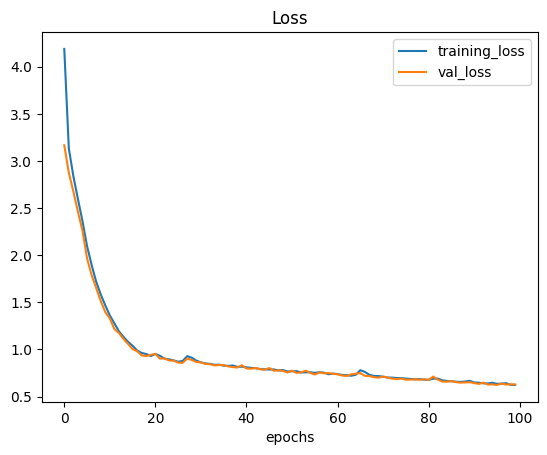

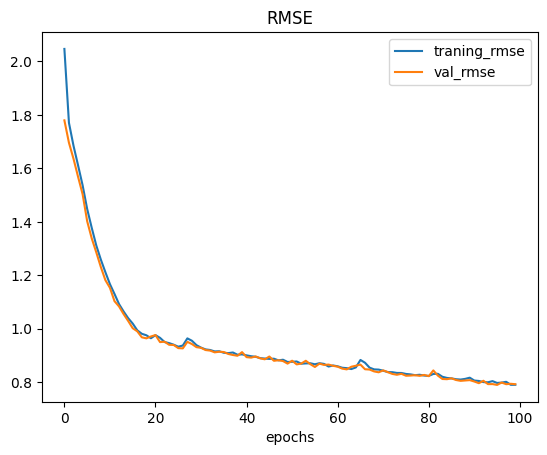

In [23]:
plot_loss_curves(history)

In [32]:
datahandler.train_steps_per_epoch

10

In [33]:
datahandler.test_steps_per_epoch

3

In [7]:
model.summary()

Model: "ngcf_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embeddings (Embedding)  multiple                 241408    
                                                                 
 item_embeddings (Embedding)  multiple                 425984    
                                                                 
 ngcf_layer (NGCFLayer)      multiple                  131072    
                                                                 
 ngcf_layer_1 (NGCFLayer)    multiple                  131072    
                                                                 
 ngcf_layer_2 (NGCFLayer)    multiple                  131072    
                                                                 
 ngcf_layer_3 (NGCFLayer)    multiple                  131072    
                                                                 
Total params: 1,191,680
Trainable params: 1,191,680
Non-

In [9]:
users * 256

241408

In [14]:
model.ngcf_layers[0].weights

[<tf.Variable 'W1:0' shape=(256, 256) dtype=float32, numpy=
 array([[-0.02381365, -0.06333484,  0.05390237, ..., -0.00934806,
          0.03633124,  0.06322516],
        [-0.10280971, -0.00351223, -0.05579541, ..., -0.08929774,
         -0.10733709,  0.00855567],
        [ 0.00099425,  0.08217365,  0.02951336, ..., -0.01764023,
         -0.0242143 ,  0.04056758],
        ...,
        [-0.10100131,  0.00392398, -0.05091558, ...,  0.05484069,
         -0.02931533, -0.00652715],
        [-0.08714195, -0.04526706, -0.07973477, ...,  0.01380862,
         -0.0441304 ,  0.00906649],
        [-0.03784003, -0.0530493 , -0.06862675, ...,  0.01037571,
         -0.09293465, -0.02971027]], dtype=float32)>,
 <tf.Variable 'W2:0' shape=(256, 256) dtype=float32, numpy=
 array([[ 8.37165713e-02, -9.11681801e-02, -6.28606901e-02, ...,
          1.04502909e-01, -5.29747740e-05,  7.75967538e-02],
        [-7.70965684e-03,  6.58849776e-02, -1.04667675e-02, ...,
          6.19736426e-02,  6.02370948e-02,  5.

In [15]:
2 * 256 * 256

131072

In [2]:
import tensorflow as tf

# Lists the available GPUs
gpus = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))

# Checking GPU utilization
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Num GPUs Available:  1
Name: /physical_device:GPU:0   Type: GPU
